In [52]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline


1. intro
2. micrograd overview
3. derivative of a simple function with one input
4. derivative of a function with multiple inputs
5. starting the core Value object of micrograd and its visualization
6. manual backpropagation example #1: simple expression
7. preview of a single optimization step
8. manual backpropagation example #2: a neuron
9. implementing the backward function for each operation
10. implementing the backward function for a whole expression graph
11. fixing a backprop bug when one node is used multiple times
12. breaking up a tanh, exercising with more operations
13. doing the same thing but in PyTorch: comparison
14. building out a neural net library (multi-layer perceptron) in micrograd
15. creating a tiny dataset, writing the loss function
16. collecting all of the parameters of the neural net
17. doing gradient descent optimization manually, training the network
18. summary of what we learned, how to go towards modern neural nets
19. walkthrough of the full code of micrograd on github
20. real stuff: diving into PyTorch, finding their backward pass for tanh
21. conclusion

## 3. derivative of a simple function with one input

In [9]:
def f(x):
    return 3*x**2 - 4*x + 5

In [10]:
f(3)

20

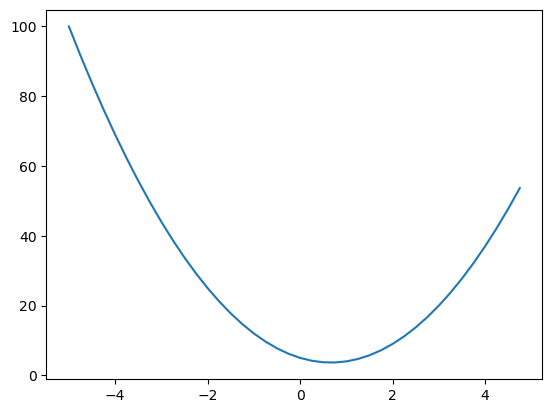

In [11]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

## 4. derivative of a function with multiple inputs

In [12]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [13]:
## lets start the complex topic
a = 2.0
b = -3.0
c = 10.0
d = a*b +c 
print(d)

4.0


In [14]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
c += h
d2 = a*b +c

print("d1:",d1)
print("d2:",d2)
print('slope:',(d2-d1)/h)

d1: 4.0
d2: 4.0009999999999994
slope: 0.9999999999994458


## 5. starting the core Value object of micrograd and its visualization

In [104]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

5. starting the core Value object of micrograd and its visualization

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

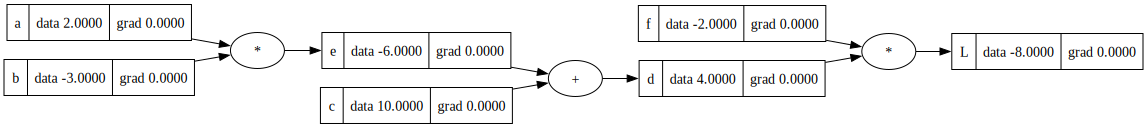

In [17]:
draw_dot(L)

In [18]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c  
L = d * f

print(L.data)

-8.0


In [20]:
def lol():
    h = 0.001
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label = 'e'
    d = e+c;d.label = 'd'
    f = Value(-2.0,label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

    

-3.9999999999995595


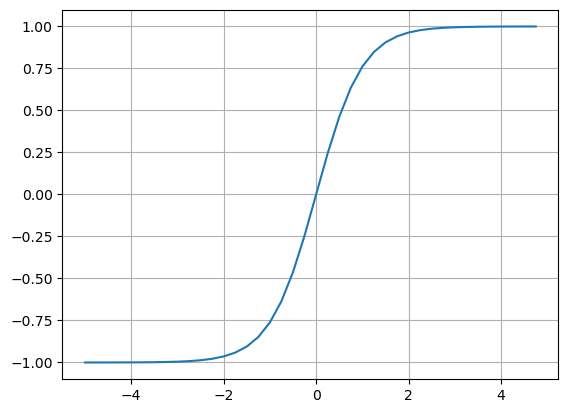

In [24]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25))); plt.grid();

In [25]:
# 2 inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label = 'w2')
# Bias of neuron
b = Value(6.8814154151,label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 * x2w2; x1w1x2w2.label = 'x1*w1 +x2w2'
n = x1w1x2w2 +b; n.label = 'n'
o = n.tanh(); o.label = 'o'

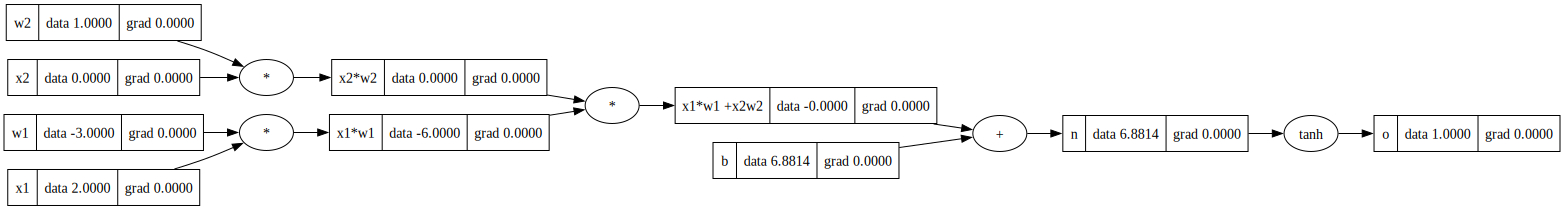

In [26]:
draw_dot(o)

In [27]:
o.backward()

In [28]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data= -3.0),
 Value(data= 2.0),
 Value(data= -6.0),
 Value(data= 0.0),
 Value(data= 1.0),
 Value(data= 0.0),
 Value(data= -0.0),
 Value(data= 6.8814154151),
 Value(data= 6.8814154151),
 Value(data= 0.999997891818233)]

In [29]:
o.grad = 1.0

In [31]:
o._backward()

In [32]:
n._backward()

In [33]:
b._backward()

In [34]:
x1w1x2w2._backward()

In [35]:
x2w2._backward()
x1w1._backward()

In [36]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [37]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [38]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [39]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [40]:
n.grad = 0.5

In [41]:
o.grad = 1.0

In [42]:
1 - o.data**2

4.216359089648236e-06

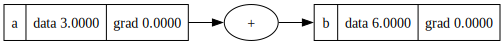

In [43]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

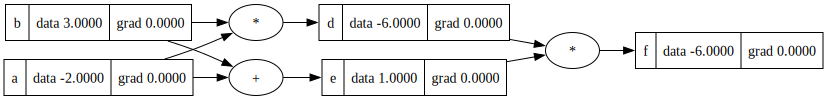

In [44]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [48]:
import torch

In [51]:
x1=torch.Tensor([2.0]).double(); x1.requires_grad = True
x2=torch.Tensor([0.0]).double(); x2.requires_grad = True
w1=torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2=torch.Tensor([1.0]).double(); w2.requires_grad = True
b=torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:
from typing import Any


class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
    def paramters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def paramters(self):
        return [p for neuron in self.neurons for p in neuron.paramters()]
    
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.paramters()]

In [84]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data= -0.29225423140710294)

In [85]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0]

In [105]:
for i in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #Update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(i, loss.data)

0 5.134520386227435
1 2.0015751554534
2 0.8957608970846536
3 0.537282494954729
4 0.28550610358493267
5 0.15502990351384094
6 0.12093928245711147
7 0.09899477534997395
8 0.08339157088496726
9 0.07177557883558876
10 0.06282540956313001
11 0.05573881964883454
12 0.05000207424729379
13 0.04527195531063394
14 0.04131101087319848
15 0.03795006353208788
16 0.035065520032905945
17 0.032565114012991704
18 0.03037865398103971
19 0.028451848520448686
